<a href="https://colab.research.google.com/github/SalhaAlzahrani/MS_Trust/blob/main/Ablation_MY_Affine_CutMix_MixUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Ablation study: MS-Trust: MixUp and CutMix
*   Axial & Sagittal
*   MY-DS (MY/MS/TC) dataset

In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 12.3 MB/s eta 0:00:00


In [ ]:
import os
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
from google.colab import drive

# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

# 🈺 Hyperparameters



In [ ]:
######################
NUM_CLASSES = 3
######################
positional_emb = True
conv_layers = 2
projection_dim = 128
num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
stochastic_depth_rate = 0.1
learning_rate = 0.001
weight_decay = 0.0001
NUM_EPOCHS = 100
IMG_SIZE =224
BATCH_SIZE = 32
input_shape = (224, 224, 3)

np.random.seed(42)
tf.random.set_seed(42)
AUTO = tf.data.AUTOTUNE

In [ ]:
def preprocess_image(path):
    image = tf.keras.utils.load_img(path)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image

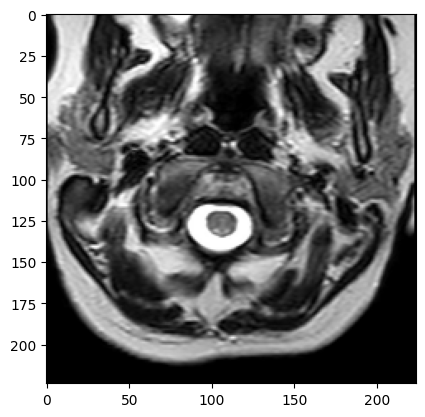

In [ ]:
plt.imshow(preprocess_image(os.path.join("/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/myelitis/", "1 (1).jpg" )))

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    epochs = range(len(history.history['loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.')
    ax1.plot(epochs, val_loss, label='val_loss', marker='.')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.legend();


---
# 🧠 Load Myelitis Dataset




In [ ]:
# Folder "TC" consist of MRI scans having Typical subjects (with no MS)
nest_asyncio.apply()
TC_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/control/", x)
    for x in os.listdir("/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/control/")
]
# Folder "MS" consist of MRI scans having several MS
nest_asyncio.apply()
MS_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/ms/", x)
    for x in os.listdir("/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/ms/")
]
# Folder "MY" consist of MRI scans having several Myelitis
nest_asyncio.apply()
MY_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/myelitis/", x)
    for x in os.listdir("/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/myelitis/")
]
n_TC = len(TC_scan_paths)
n_MS = len(MS_scan_paths)
n_MY = len(MY_scan_paths)
r_TC = round(n_TC * 0.8)
r_MS = round(n_MS * 0.8)
r_MY = round(n_MY * 0.8)
print("MRI scans with TC: " + str(n_TC) + ' round: ' + str(r_TC))
print("MRI scans with MS: " + str(n_MS) + ' round: ' + str(r_MS))
print("MRI scans with MY: " + str(n_MY) + ' round: ' + str(r_MY))

MRI scans with TC: 1398 round: 1118
MRI scans with MS: 667 round: 534
MRI scans with MY: 706 round: 565


In [ ]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
nest_asyncio.apply()
TC_scans = np.array([preprocess_image(path)  for path in TC_scan_paths])
nest_asyncio.apply()
MS_scans = np.array([preprocess_image(path) for path in MS_scan_paths])
nest_asyncio.apply()
MY_scans = np.array([preprocess_image(path) for path in MY_scan_paths])

In [ ]:
# For the scans having presence of MS assign 1, MY assign 2, for the typical control TC ones assign 0.
nest_asyncio.apply()
TC_labels = np.array([0 for _ in range(len(TC_scans))])
nest_asyncio.apply()
MS_labels = np.array([1 for _ in range(len(MS_scans))])
nest_asyncio.apply()
MY_labels = np.array([2 for _ in range(len(MY_scans))])

# Split data in the ratio 80%-20% for training and validation.
x_train1 = np.concatenate((MY_scans[:r_MY], MS_scans[:r_MS]), axis=0)
x_train = np.concatenate((x_train1, TC_scans[:r_TC]), axis=0)
y_train1 = np.concatenate((MY_labels[:r_MY], MS_labels[:r_MS]), axis=0)
y_train = np.concatenate((y_train1, TC_labels[:r_TC]), axis=0)
x_val1 = np.concatenate((MY_scans[r_MY:], MS_scans[r_MS:]), axis=0)
x_val = np.concatenate((x_val1, TC_scans[r_TC:]), axis=0)
y_val1 = np.concatenate((MY_labels[r_MY:], MS_labels[r_MS:]), axis=0)
y_val = np.concatenate((y_val1, TC_labels[r_TC:]), axis=0)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 2217 and 554.


# 🅰 Data augmentation

In the original paper, the authors use AutoAugment to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping. https://arxiv.org/abs/1805.09501

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.CenterCrop(height=IMG_SIZE, width=IMG_SIZE)
])

In [ ]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
)

aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
aug_ds = (
    aug_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_ds = (
    validation_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# 🅰 Define the MixUp function


To perform the mixup routine, we create new virtual datasets using the training data from the same dataset, and apply a lambda value within the [0, 1] range sampled from a Beta distribution — such that, for example, new_x = lambda * x1 + (1 - lambda) * x2 (where x1 and x2 are images) and the same equation is applied to the labels as well.


In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def mix_up(train_ds_one, train_ds_two):
    alpha=0.2
     # Unpack two datasets
    images_one, labels_one = train_ds_one
    images_two, labels_two = train_ds_two
    batch_size = 1

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = l
    y_l = l

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:
train_ds_one_A = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
)
train_ds_two_A = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
)
# Combine two shuffled datasets from the same training data.
train_ds_A = tf.data.Dataset.zip((train_ds_one_A, train_ds_two_A))

validation_ds_A = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_ds_A = (
    validation_ds_A
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Create the new dataset using our `cutmix` utility
train_ds_cmu_A = (
    train_ds_A.shuffle(1024)
    .map(mix_up, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# 🅰 Define the CutMix function

---


The CutMix function takes two image and label pairs to perform the augmentation. It samples λ(l) from the Beta distribution and returns a bounding box from get_box function. We then crop the second image (image2) and pad this image in the final padded image at the same location.

*Note: we are combining two images to create a single one*

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)
    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)
    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)
    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32 )

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [ ]:
train_ds_one_B = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
)
train_ds_two_B = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
)
# Combine two shuffled datasets from the same training data.
train_ds_B = tf.data.Dataset.zip((train_ds_one_B, train_ds_two_B))

validation_ds_B = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_ds_B = (
    validation_ds_B
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Create the new dataset using our `cutmix` utility
train_ds_cmu_B = (
    train_ds_B.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# ♒ Stochastic depth for regularization

Stochastic depth is a regularization technique that randomly drops a set of layers. During inference, the layers are kept as they are. It is very much similar to Dropout but only that it operates on a block of layers rather than individual nodes present inside a layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers encoder.

In [ ]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

# ♒ SqueezeExcite & MLP




In [ ]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in https://arxiv.org/abs/1709.01507.
    Args:
        ratio: The ratio with which the feature map needs to be reduced in the reduction phase.
    Inputs:
        Convolutional features.
    Outputs:
        Attention modified feature maps.
    """
    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

################### This is for MS-Trust ##############
def mlp2(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        SqueezeExcite(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
################### This is for CCT ##############
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



---


# ✅ Affine
Use: aug_ds, validation_ds

# 🈺 Ablation study: #1 Hyperparameters



In [ ]:
#MS-Trust TE=1, SE=1, Conv=2
transformer_layers = 1
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=2, SE=1, Conv=2
transformer_layers = 2
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=3, SE=1, Conv=2
transformer_layers = 3
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=2, SE=2, Conv=2
transformer_layers = 2
squeeze_excite_layers = 2
conv_layers = 2

In [ ]:
#MS-Trust TE=3, SE=2, Conv=2
transformer_layers = 3
squeeze_excite_layers = 2
conv_layers = 2

# ⛓ The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

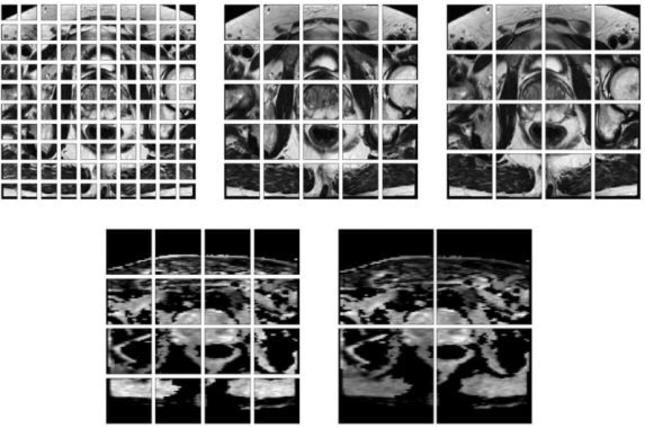

We already know that convolutions are quite good at exploiting locality information. So, based on this, the authors introduce an all-convolution mini-network to produce image patches.

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# ⛓ The final CCT model



In [ ]:
def create_cct_model(
    image_size=IMG_SIZE,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp2(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply SqueezeExcite
    if squeeze_excite_layers == 2:
      encoded_patches = mlp2(encoded_patches, hidden_units=transformer_units, dropout_rate=0.1)

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES , activation="softmax")(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
model = create_cct_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 cct_tokenizer_4 (CCTTokeni  (None, 3136, 128)            75456     ['input_5[0][0]']             
 zer)                                                                                             
                                                                                                  
 tf.__operators__.add_4 (TF  (None, 3136, 128)            0         ['cct_tokenizer_4[0][0]']     
 OpLambda)                                                                                        
                                                                                            

In [ ]:
#Re-Run
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
        ],
    )
history = model.fit(aug_ds,
                    validation_data=validation_ds,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/100
70/70 [==============================] - 35s 431ms/step - loss: 0.8709 - accuracy: 0.6689 - precision_4: 0.7573 - recall_4: 0.5756 - auc_4: 0.8499 - f1_score: 0.5468 - val_loss: 0.7515 - val_accuracy: 0.6480 - val_precision_4: 0.6839 - val_recall_4: 0.5975 - val_auc_4: 0.8855 - val_f1_score: 0.4870
Epoch 2/100
70/70 [==============================] - 29s 420ms/step - loss: 0.7448 - accuracy: 0.7271 - precision_4: 0.7846 - recall_4: 0.6130 - auc_4: 0.8915 - f1_score: 0.5864 - val_loss: 0.6780 - val_accuracy: 0.7130 - val_precision_4: 0.7318 - val_recall_4: 0.6697 - val_auc_4: 0.9164 - val_f1_score: 0.5790
Epoch 3/100
70/70 [==============================] - 29s 420ms/step - loss: 0.6689 - accuracy: 0.7564 - precision_4: 0.8040 - recall_4: 0.6996 - auc_4: 0.9220 - f1_score: 0.6676 - val_loss: 0.6486 - val_accuracy: 0.7527 - val_precision_4: 0.8042 - val_recall_4: 0.6968 - val_auc_4: 0.9307 - val_f1_score: 0.6524
Epoch 4/100
70/70 [==============================] - 29s 421ms/s

# ❤ Let's visualize the training progress of the model.


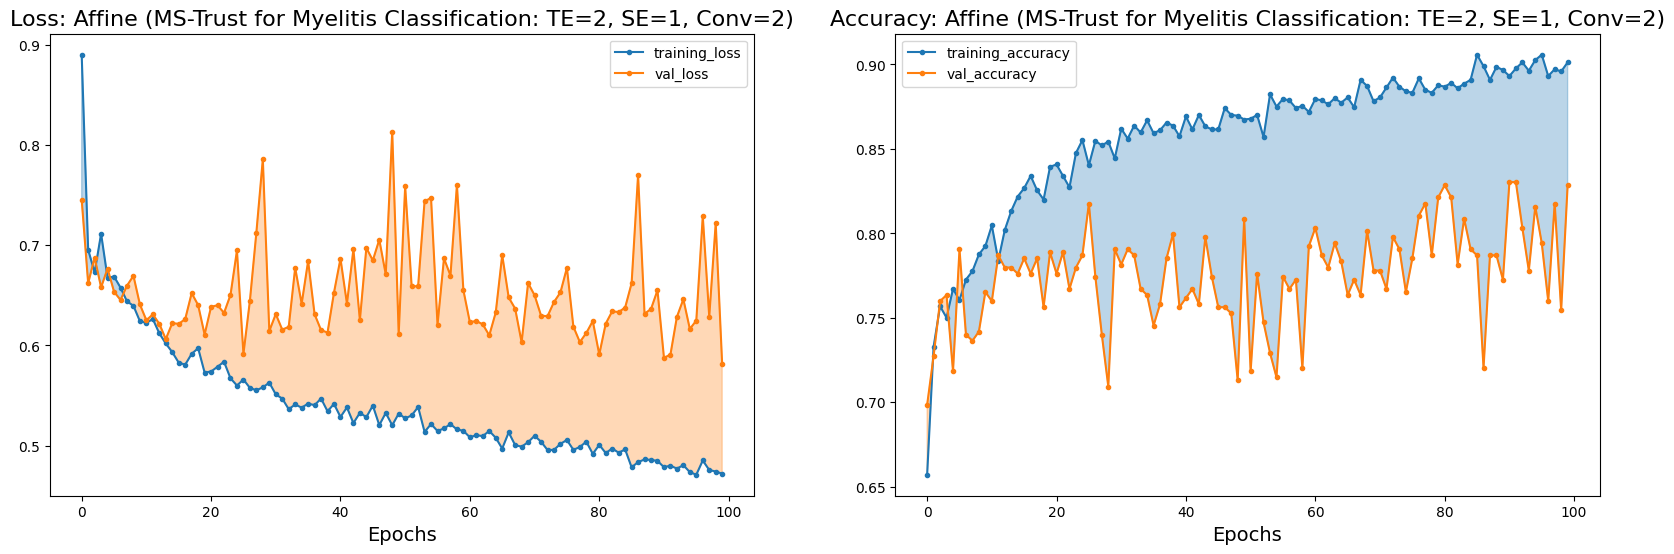

In [ ]:
plot_training_curves(history, 'Affine (MS-Trust for Myelitis Classification: TE=2, SE=1, Conv=2)')

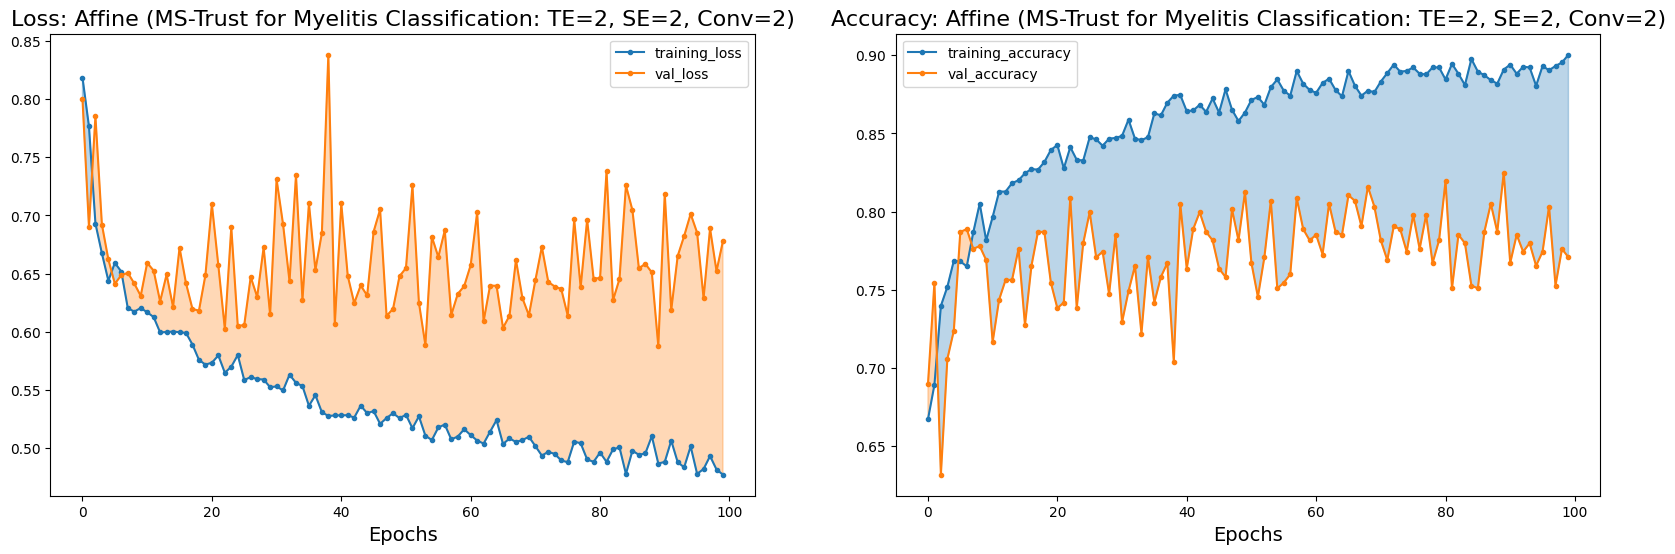

In [ ]:
plot_training_curves(history, 'Affine (MS-Trust for Myelitis Classification: TE=2, SE=2, Conv=2)')

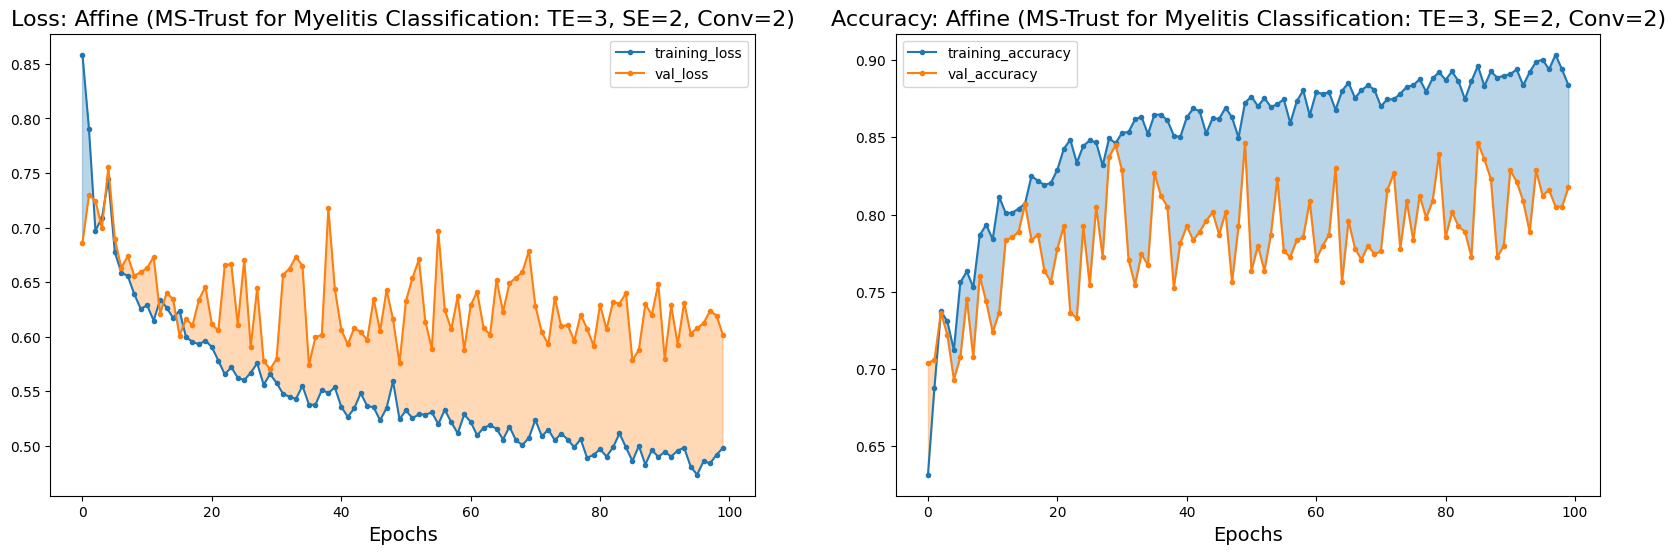

In [ ]:
plot_training_curves(history, 'Affine (MS-Trust for Myelitis Classification: TE=3, SE=2, Conv=2)')



---

# ⏰ Flush memory varibales before using the next transfomer

In [ ]:
del history
del model
del optimizer



---


# ✅ MixUp
Use: train_ds_cmu_A, validation_ds_A

# 🈺 Ablation study: #2 Hyperparameters



In [ ]:
#MS-Trust TE=1, SE=1, Conv=2
transformer_layers = 1
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=2, SE=1, Conv=2
transformer_layers = 2
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=3, SE=1, Conv=2
transformer_layers = 3
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=2, SE=2, Conv=2
transformer_layers = 2
squeeze_excite_layers = 2
conv_layers = 2

In [ ]:
#MS-Trust TE=3, SE=2, Conv=2
transformer_layers = 3
squeeze_excite_layers = 2
conv_layers = 2

# ⛓ The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

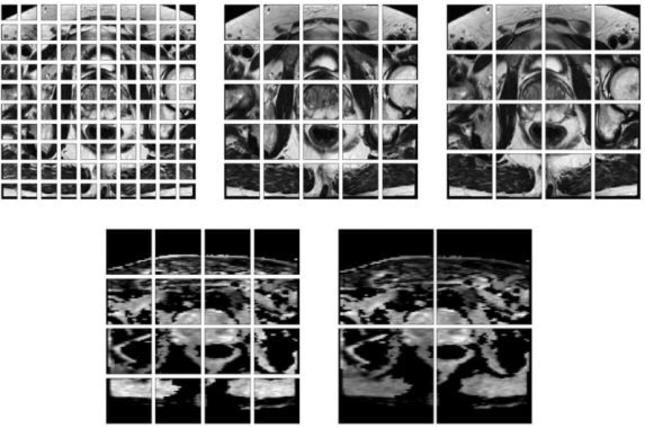

We already know that convolutions are quite good at exploiting locality information. So, based on this, the authors introduce an all-convolution mini-network to produce image patches.

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# ⛓ The final CCT model



In [ ]:
def create_cct_model(
    image_size=IMG_SIZE,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp2(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply SqueezeExcite
    if squeeze_excite_layers == 2:
      encoded_patches = mlp2(encoded_patches, hidden_units=transformer_units, dropout_rate=0.1)

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES , activation="softmax")(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
model = create_cct_model()

In [ ]:
#Re-Run
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
        ],
    )
history = model.fit(train_ds_cmu_A,
                    validation_data=validation_ds_A,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/100
70/70 [==============================] - 27s 300ms/step - loss: 0.8959 - accuracy: 0.6319 - precision_9: 0.8310 - recall_9: 0.3589 - auc_9: 0.7419 - f1_score: 0.4424 - val_loss: 0.8632 - val_accuracy: 0.6552 - val_precision_9: 0.7002 - val_recall_9: 0.5523 - val_auc_9: 0.8337 - val_f1_score: 0.4711
Epoch 2/100
70/70 [==============================] - 20s 288ms/step - loss: 0.7584 - accuracy: 0.7176 - precision_9: 0.8570 - recall_9: 0.4497 - auc_9: 0.7883 - f1_score: 0.5748 - val_loss: 0.7095 - val_accuracy: 0.7509 - val_precision_9: 0.7750 - val_recall_9: 0.6715 - val_auc_9: 0.9037 - val_f1_score: 0.6157
Epoch 3/100
70/70 [==============================] - 20s 288ms/step - loss: 0.7161 - accuracy: 0.7524 - precision_9: 0.8807 - recall_9: 0.4862 - auc_9: 0.8076 - f1_score: 0.6239 - val_loss: 0.6614 - val_accuracy: 0.7256 - val_precision_9: 0.7380 - val_recall_9: 0.6913 - val_auc_9: 0.9197 - val_f1_score: 0.6037
Epoch 4/100
70/70 [==============================] - 20s 288ms/s

# ❤ Let's visualize the training progress of the model.


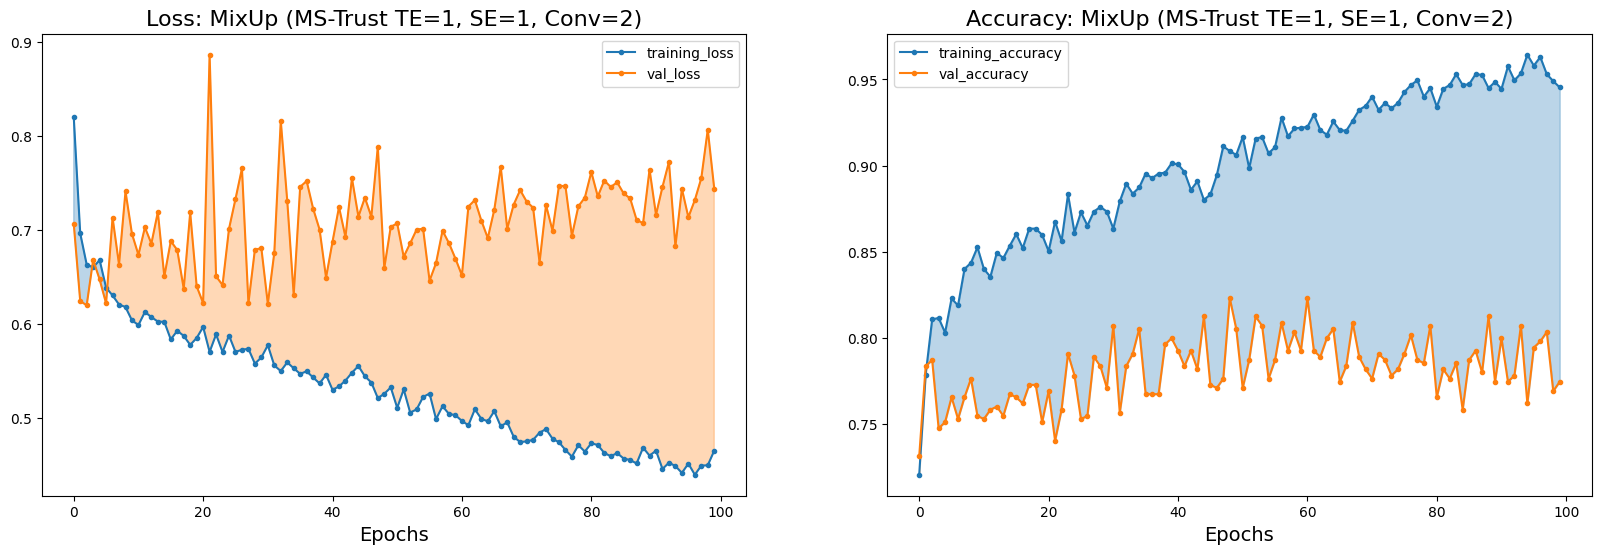

In [ ]:
plot_training_curves(history, 'MixUp (MS-Trust TE=1, SE=1, Conv=2)')

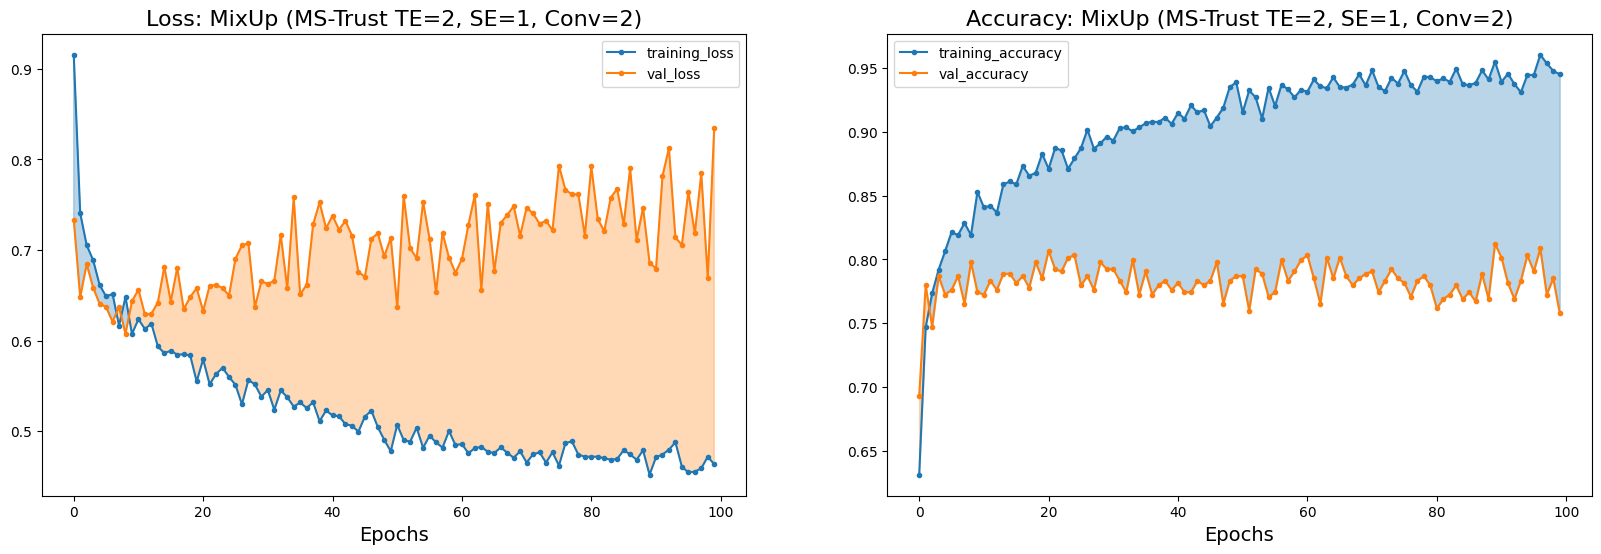

In [ ]:
plot_training_curves(history, 'MixUp (MS-Trust TE=2, SE=1, Conv=2)')

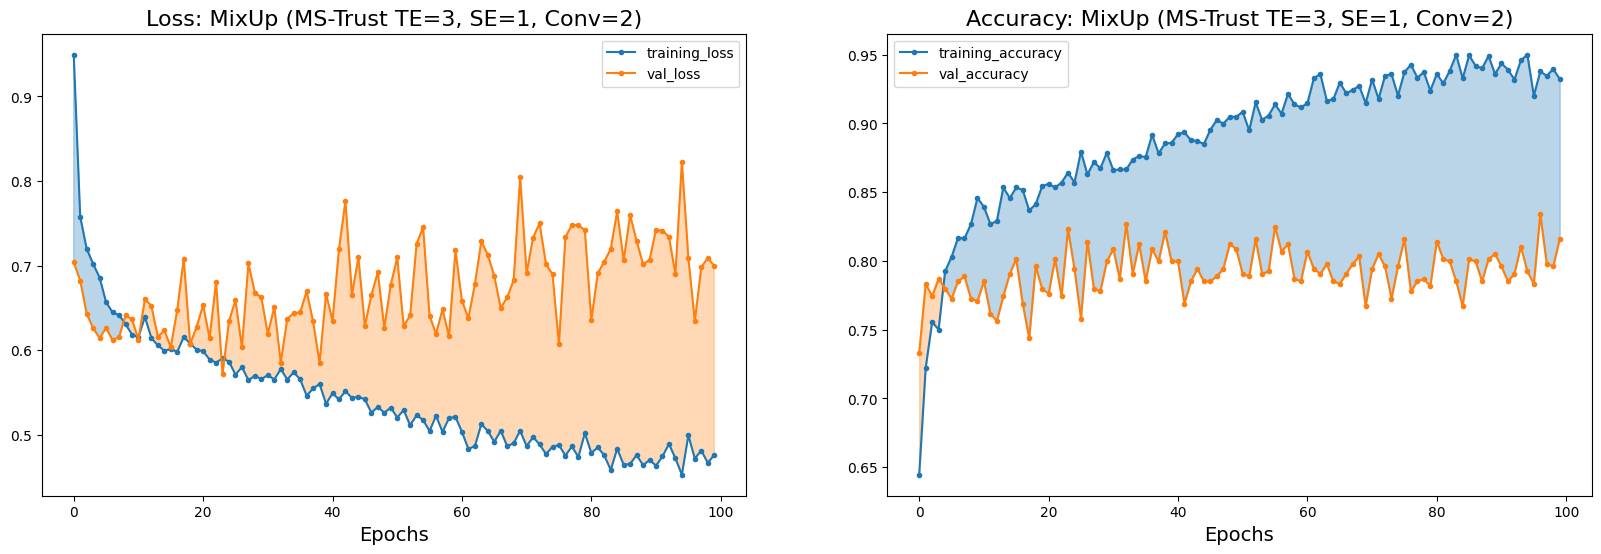

In [ ]:
plot_training_curves(history, 'MixUp (MS-Trust TE=3, SE=1, Conv=2)')

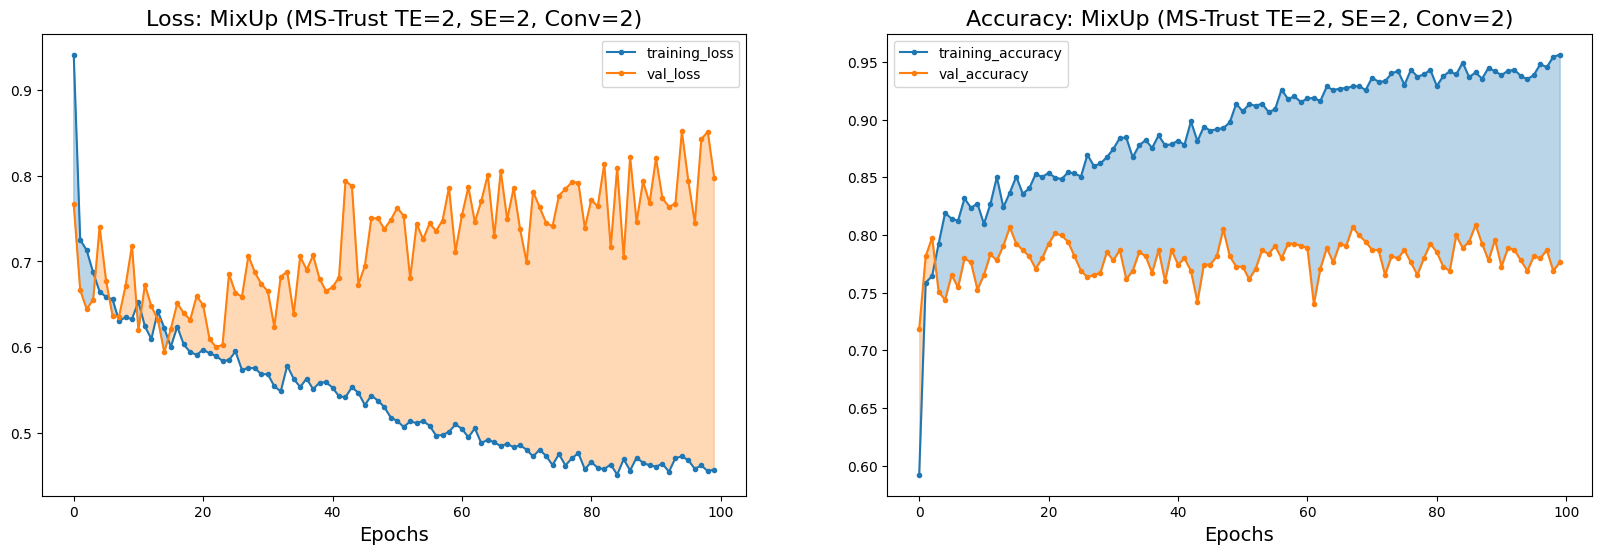

In [ ]:
plot_training_curves(history, 'MixUp (MS-Trust TE=2, SE=2, Conv=2)')

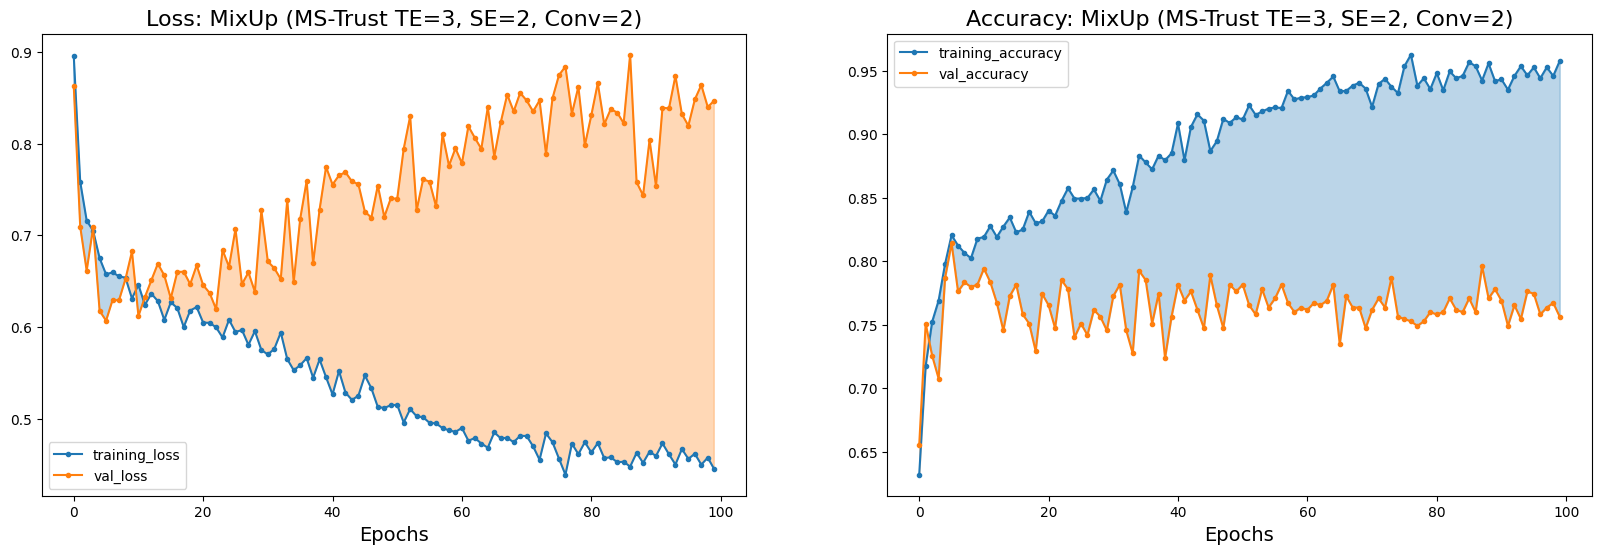

In [ ]:
plot_training_curves(history, 'MixUp (MS-Trust TE=3, SE=2, Conv=2)')



---

# ⏰ Flush memory varibales before using the next transfomer

In [ ]:
del history
del model
del optimizer



---


# ✅ CutMix
Use: train_ds_cmu_B, validation_ds_B

# 🈺 Ablation study: #3 Hyperparameters



In [ ]:
#MS-Trust TE=1, SE=1, Conv=2
transformer_layers = 1
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=2, SE=1, Conv=2
transformer_layers = 2
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=3, SE=1, Conv=2
transformer_layers = 3
squeeze_excite_layers = 1
conv_layers = 2

In [ ]:
#MS-Trust TE=2, SE=2, Conv=2
transformer_layers = 2
squeeze_excite_layers = 2
conv_layers = 2

In [ ]:
#MS-Trust TE=3, SE=2, Conv=2
transformer_layers = 3
squeeze_excite_layers = 2
conv_layers = 2

# ⛓ The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

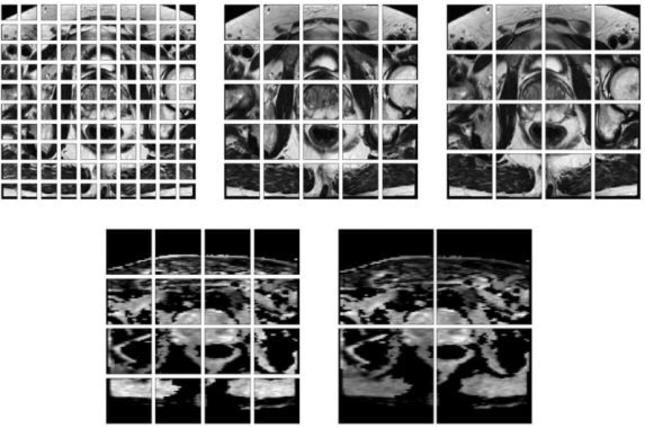

We already know that convolutions are quite good at exploiting locality information. So, based on this, the authors introduce an all-convolution mini-network to produce image patches.

In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# ⛓ The final CCT model



In [ ]:
def create_cct_model(
    image_size=IMG_SIZE,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp2(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply SqueezeExcite
    if squeeze_excite_layers == 2:
      encoded_patches = mlp2(encoded_patches, hidden_units=transformer_units, dropout_rate=0.1)

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES , activation="softmax")(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
model = create_cct_model()

In [ ]:
#Re-Run
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
        ],
    )
history = model.fit(train_ds_cmu_B,
                    validation_data=validation_ds_B,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/100
70/70 [==============================] - 26s 300ms/step - loss: 0.9417 - accuracy: 0.6283 - precision_16: 0.8584 - recall_16: 0.3194 - auc_16: 0.7355 - f1_score: 0.3623 - val_loss: 0.7003 - val_accuracy: 0.7744 - val_precision_16: 0.7933 - val_recall_16: 0.7274 - val_auc_16: 0.9114 - val_f1_score: 0.6909
Epoch 2/100
70/70 [==============================] - 20s 288ms/step - loss: 0.8049 - accuracy: 0.7028 - precision_16: 0.8930 - recall_16: 0.4316 - auc_16: 0.8154 - f1_score: 0.5356 - val_loss: 0.6776 - val_accuracy: 0.7310 - val_precision_16: 0.7407 - val_recall_16: 0.7220 - val_auc_16: 0.9254 - val_f1_score: 0.5408
Epoch 3/100
70/70 [==============================] - 20s 287ms/step - loss: 0.7756 - accuracy: 0.7113 - precision_16: 0.8955 - recall_16: 0.4568 - auc_16: 0.8301 - f1_score: 0.5570 - val_loss: 0.6398 - val_accuracy: 0.7852 - val_precision_16: 0.7861 - val_recall_16: 0.7563 - val_auc_16: 0.9315 - val_f1_score: 0.6910
Epoch 4/100
70/70 [===========================

# ❤ Let's visualize the training progress of the model.


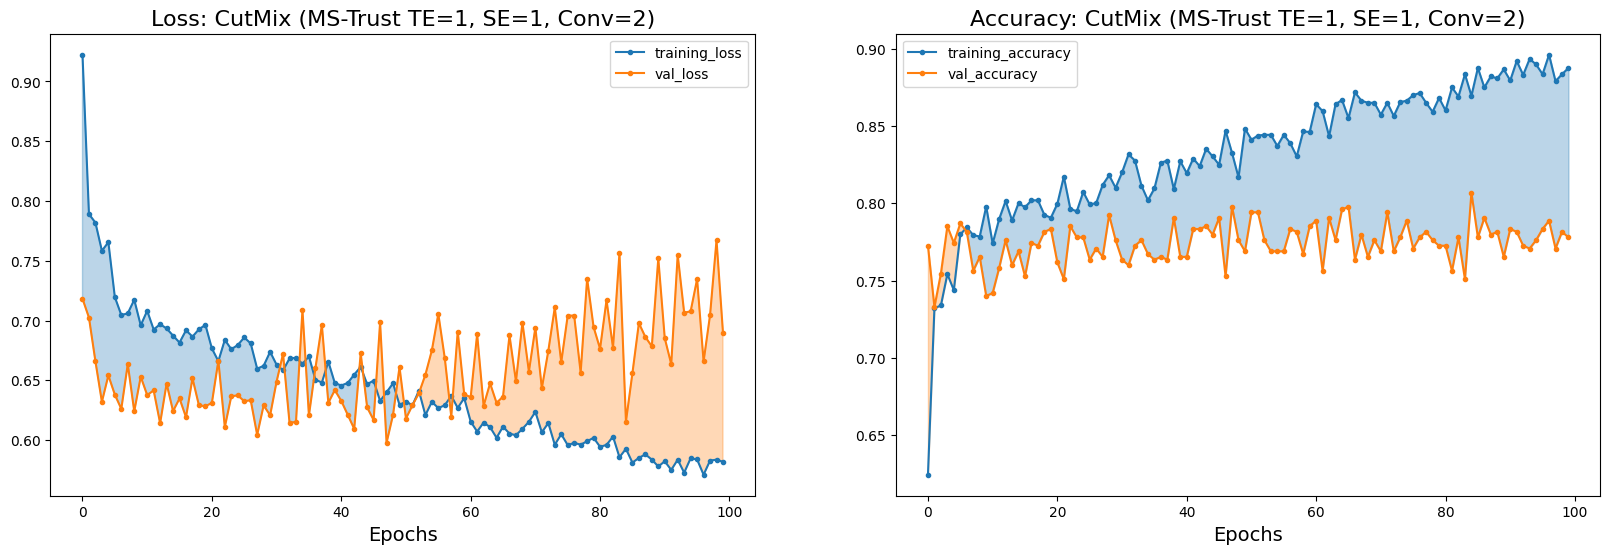

In [ ]:
plot_training_curves(history, 'CutMix (MS-Trust TE=1, SE=1, Conv=2)')

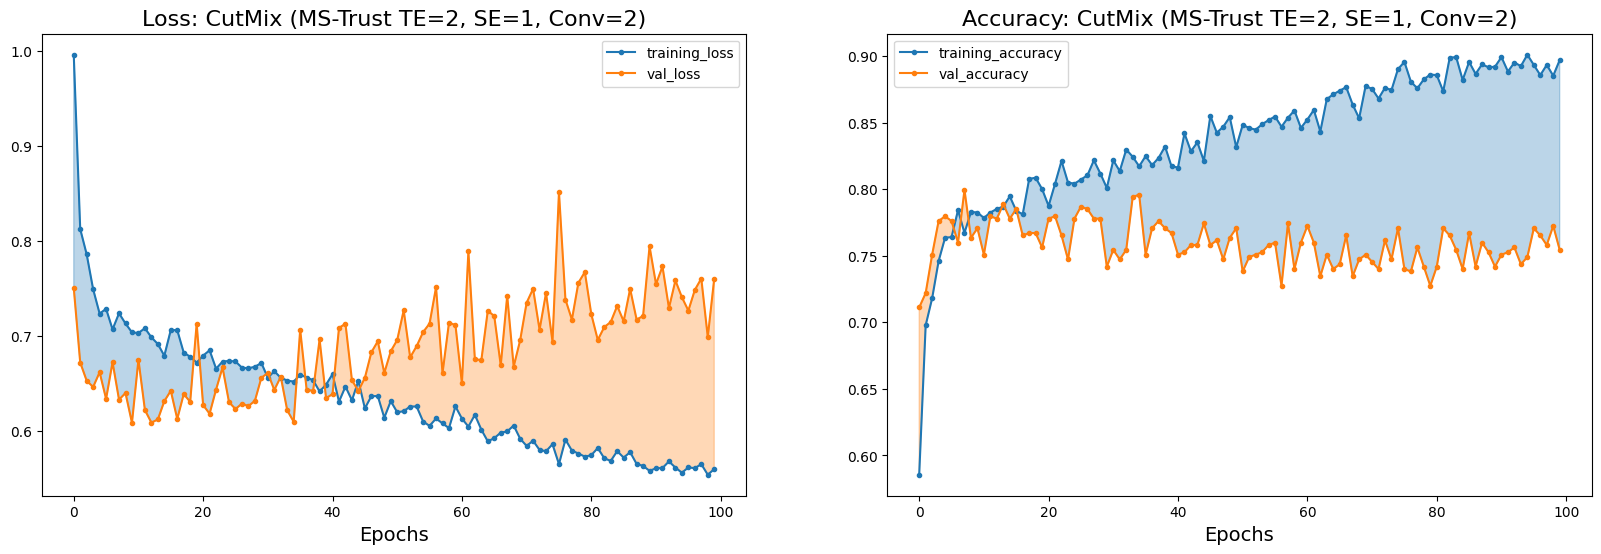

In [ ]:
plot_training_curves(history, 'CutMix (MS-Trust TE=2, SE=1, Conv=2)')

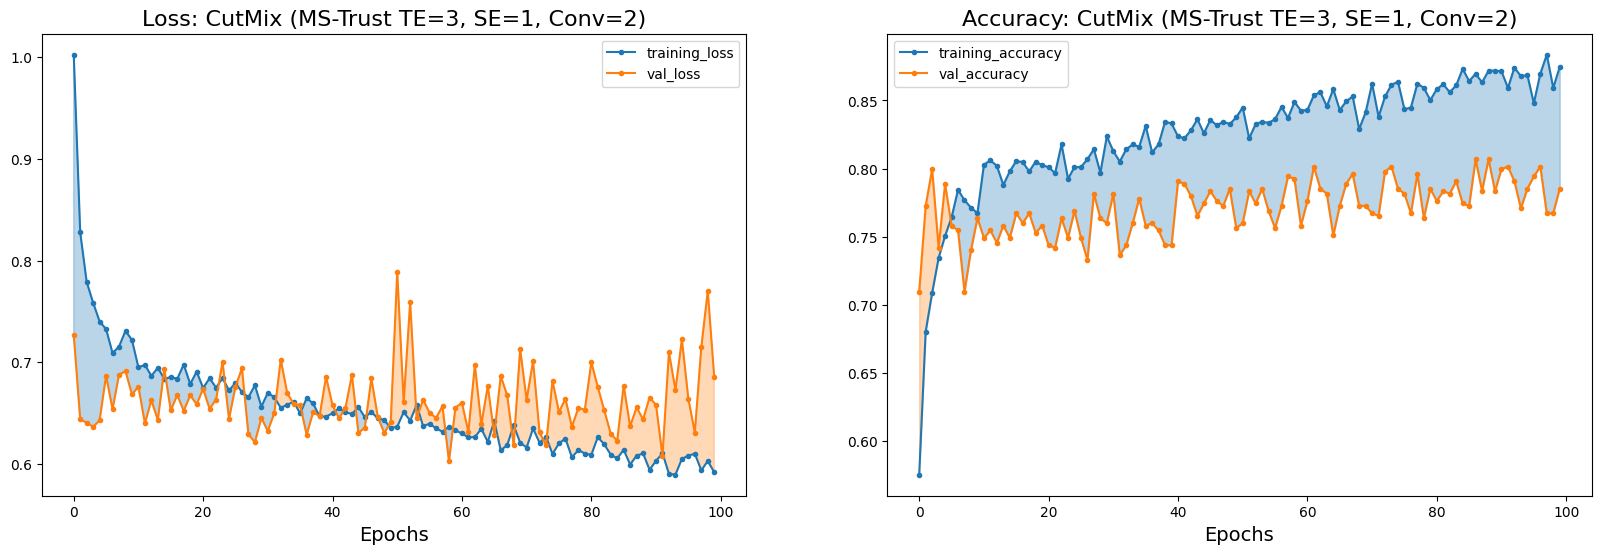

In [ ]:
plot_training_curves(history, 'CutMix (MS-Trust TE=3, SE=1, Conv=2)')

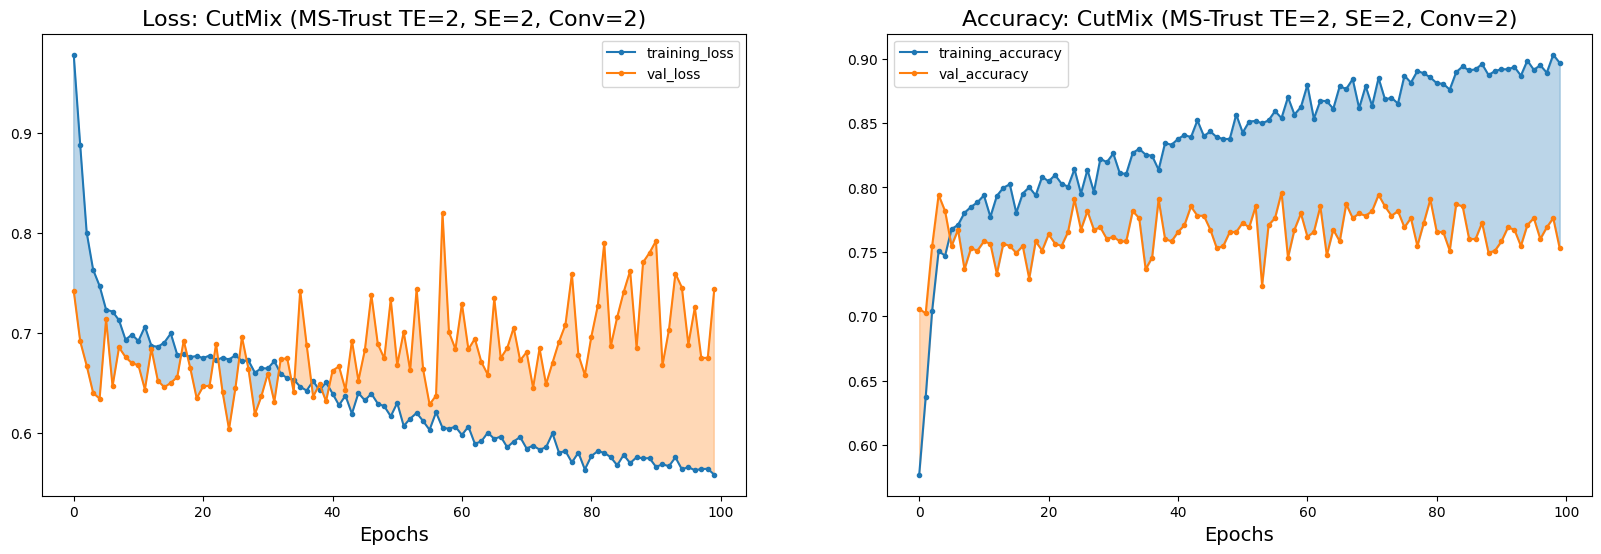

In [ ]:
plot_training_curves(history, 'CutMix (MS-Trust TE=2, SE=2, Conv=2)')

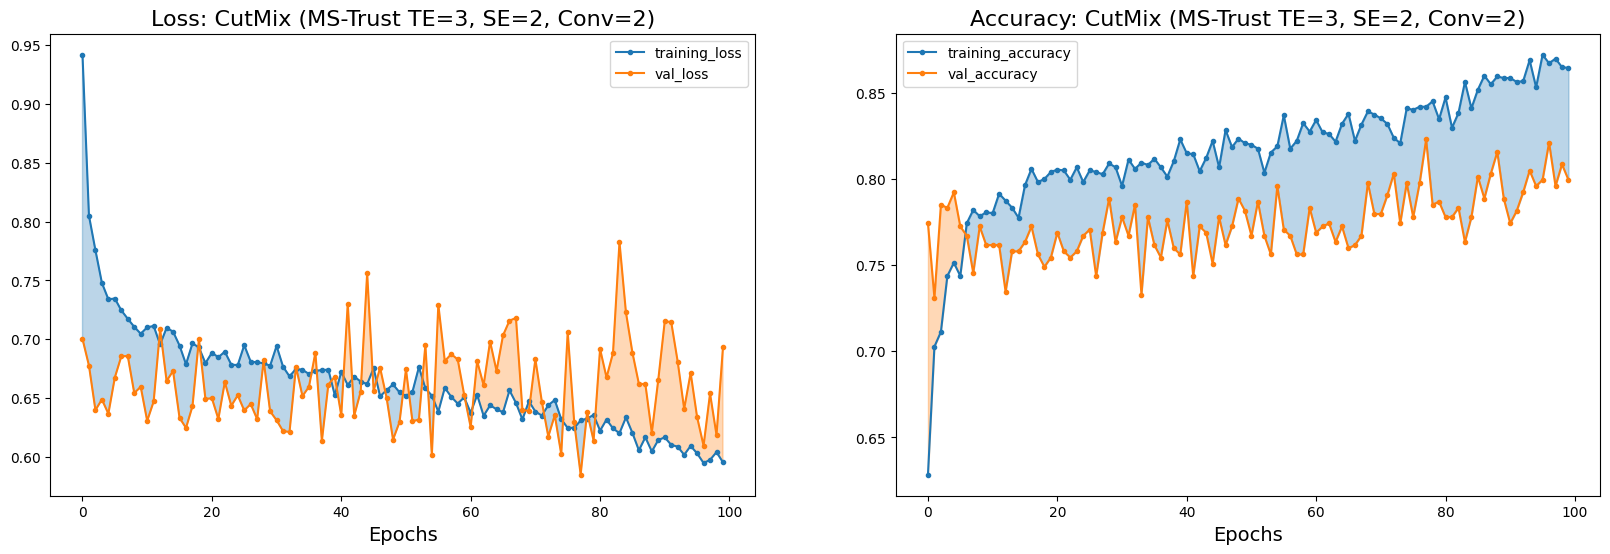

In [ ]:
plot_training_curves(history, 'CutMix (MS-Trust TE=3, SE=2, Conv=2)')



---

# ⏰ Flush memory varibales before using the next transfomer

In [ ]:
del model
del optimizer
del history